In [2]:
#%matplotlib notebook
%matplotlib inline
import sys
sys.path.append("../../NephNet")
import matplotlib.pyplot as plt
import os
import random
import shutil
import time
import warnings
import sys
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from data_loader import databases as module_datasets
from base.base_data_loader import BaseDataLoader
from trainer import Trainer
from utils import Logger
from utils import util
from utils import tSNE_test as tSNE#import Identity, tSNE_generator
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
from utils import hyperband as HypOpt
import argparse
from sklearn.model_selection import StratifiedKFold
import copy
from utils import transforms3d as t3d
import pandas as pd

import cleanlab
from cleanlab import baseline_methods
from sklearn.metrics import accuracy_score

print("Modules loaded")


importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(tSNE)
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
importlib.reload(HypOpt)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Modules loaded
Reload complete
GPUs available: 1


In [3]:
config_file = '../configs/config_kfold.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [52]:
print("GPUs available: " + str(torch.cuda.device_count()))
train_logger = Logger()
cv_seed = 1234
np.random.seed(cv_seed)
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
num_classes = config['arch']['args']['num_classes']
#cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Initialize training dataset
rs = np.random.RandomState()
mean = config['data_loader']['args']['mean']
stdev = config['data_loader']['args']['stdev']
trsfm_train = [
               t3d.RandomRotate90(rs), 
               t3d.Normalize(mean, stdev), 
               t3d.ToTensor(True)]
train_dataset = getattr(module_datasets, 
    'hdf5dataset')(config['data_loader']['args']['hdf5_path'],
    shape = config['data_loader']['args']['shape'], 
    transforms = trsfm_train,
    training = True)

snrs = np.empty(train_dataset.__len__())
means = np.empty(train_dataset.__len__())
stdevs = np.empty(train_dataset.__len__())
for i in range(train_dataset.__len__()):
    img = train_dataset.data[i]
    img = (img - mean) / stdev
    snr = np.mean(img) / np.std(img)
    means[i] = np.mean(img)
    stdevs[i] = np.std(img)
    snrs[i] = snr

print(len(snrs))
print("Mean SNR: {}".format(np.mean(snrs)))
print("Std SNR: {}".format(np.std(snrs)))

print("Mean images: {}".format(np.mean(means)))
print("Std images: {}".format(np.mean(stdevs)))

low_snr = np.where(snrs < np.mean(snrs) - np.std(snrs))[0] #all images with SNR < 1 standard deviation from the mean
print(len(low_snr))
print(low_snr)



GPUs available: 1
118681
Mean SNR: -0.1994771926668369
Std SNR: 0.6703404913677539
Mean images: 0.021810519007054722
Std images: 0.9143164858105652
13931
[    10     14     15 ... 118674 118677 118678]


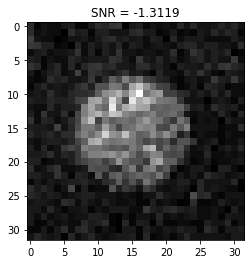

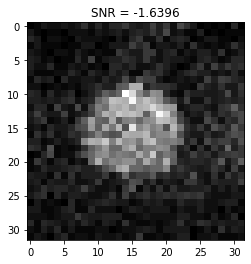

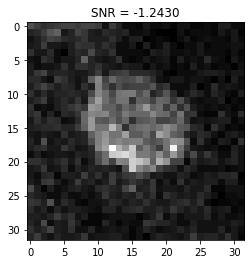

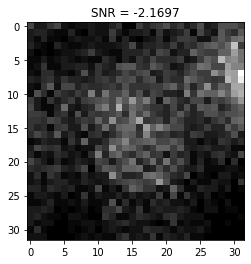

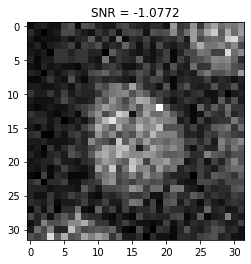

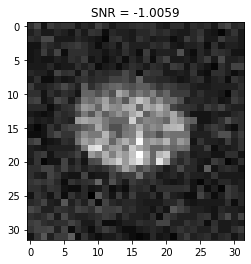

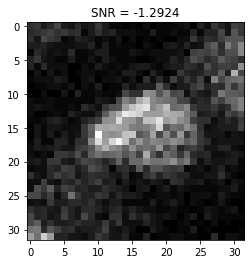

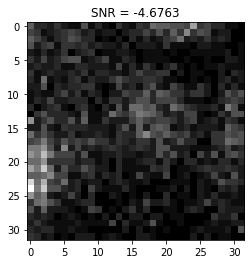

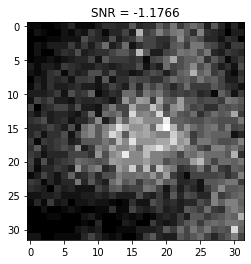

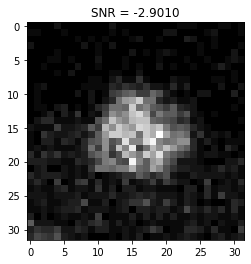

In [53]:
bad_idx = [116282,  80685,   3614,  33412,  95389,  77561,  55266,  64474,  79695,  44830,
  99434,  28054, 110283,  82795,  31901,  88407,   5098,  30636, 103697,  45858]

#low_snr = bad_idx

for idx in range(10):
    img, label = train_dataset.__getitem__(low_snr[idx])
    img_n = img #* stdev + mean
    img_n = img_n.numpy()
    snr = np.mean(img_n) / np.std(img_n)
    plt.imshow(img.numpy().squeeze()[3], cmap = 'gray')
    plt.title("SNR = {:.4f}".format(snr))
    plt.pause(0.1)

(array([2705., 3729., 5672.,  338.,  202.,  251.,  456.,   59.,  519.]),
 array([0.        , 0.88888889, 1.77777778, 2.66666667, 3.55555556,
        4.44444444, 5.33333333, 6.22222222, 7.11111111, 8.        ]),
 <a list of 9 Patch objects>)

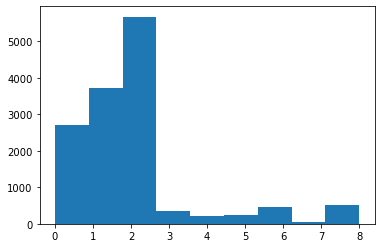

In [59]:
low_snr_labels = train_dataset.label[low_snr]-1
classes = ('S1', 'S2S3', 'TAL', 'DCT', 'CD', 'cd45', 'nestin', 'cd31_glom', 'cd31_inter')
plt.hist(low_snr_labels, bins = 9, label=classes) #show which labels have the low SNR 
#plt.xticks(classes)



In [12]:
#CREATE DATASET WITHOUT LOW SNR SAMPLES
filename = config['data_loader']['args']['hdf5_path']
path = filename.split('.')
path = path[0] + "_remove_snr2.h5"
print("NEW FILE " + path)
store = pd.HDFStore(path)
with pd.HDFStore(filename) as f:
        print()
        print("Successfully created " + path)
        print("===============")
        keys = list(f.keys())
        print("{0} keys in this file: {1}".format(len(keys), keys))
        
        num_images_train = f['Metadata']['TrainingNum'][0]
        num_images_test = f['Metadata']['TestingNum'][0]
        mean = f['Metadata']['TrainingMean'][0]
        std = f['Metadata']['TrainingStd'][0]
        '''
        num_images_train = len(f['train_data'])
        num_images_test = len(f['test_data'])
        mean = np.mean(f['train_data'].to_numpy())
        std = np.std(f['train_data'].to_numpy())
        '''
        mean_t = np.mean(f['test_data'].to_numpy())
        std_t = np.std(f['test_data'].to_numpy())
        
        print("Training images: " + str(num_images_train))
        print("Testing images: " + str(num_images_test))
        print("Training image mean = " + str(mean) + " and std = " + str(std))
        print("Testing image mean = " + str(mean_t) + " and std = " + str(std_t))
        
        train_data = f['train_data'].to_numpy()
        train_label = f['train_labels'].to_numpy()
        snrs = np.empty(num_images_train)
        for i in range(num_images_train):
            img = train_data[i]
            img = (img - mean) / std
            snr = np.mean(img) / np.std(img)
            snrs[i] = snr
        print(len(snrs))
        print("Mean SNR: {}".format(np.mean(snrs)))
        print("Std SNR: {}".format(np.std(snrs)))

        low_snr = np.where(snrs < np.mean(snrs) - np.std(snrs))[0] #all images with SNR < 1 standard deviation from the mean
        print("Total number of low snr images {}".format(len(low_snr)))
        
        train_data = np.delete(train_data, low_snr, axis = 0)
        train_label = np.delete(train_label, low_snr, axis = 0)
        train_label = train_label.squeeze()
        print(pd.DataFrame(train_label.astype(np.int64)))
        
        store.append('train_data', pd.DataFrame(train_data.astype(np.int64)))
        store.append('train_labels', pd.DataFrame(train_label.astype(np.int64)))
        
        
        
        
        
        
        #REPEAT FOR TEST
        test_data = f['test_data'].to_numpy()
        test_label = f['test_labels'].to_numpy()
        snrs = np.empty(num_images_test)
        for i in range(num_images_test):
            img = test_data[i]
            img = (img - mean) / std
            snr = np.mean(img) / np.std(img)
            snrs[i] = snr
        print(len(snrs))
        print("Mean SNR: {}".format(np.mean(snrs)))
        print("Std SNR: {}".format(np.std(snrs)))

        low_snr = np.where(snrs < np.mean(snrs) - np.std(snrs))[0] #all images with SNR < 1 standard deviation from the mean
        print("Total number of low snr images {}".format(len(low_snr)))
        
        test_data = np.delete(test_data, low_snr, axis = 0)
        test_label = np.delete(test_label, low_snr, axis = 0)
        
        store.append('test_data', pd.DataFrame(test_data.astype(np.int64)))
        store.append('test_labels', pd.DataFrame(test_label.astype(np.int64)))
        
        
        
        
        metadata = pd.DataFrame({'TrainingNum': len(train_data), 'TestingNum': len(test_data), \
                'TrainingMean': np.mean(train_data), 'TrainingStd': np.std(train_data)}, index=[0])      
        store.append('Metadata', metadata)
        store.append('test_ids', f['test_ids'])
        print(metadata)
        
        del train_data, test_data
        print("FIN")
store.close() 

with pd.HDFStore(path) as f:
        print('\n\n\n')
        print("Successfully created " + path)
        print("===============")
        keys = list(f.keys())
        print("{0} keys in this file: {1}".format(len(keys), keys))

NEW FILE C:/Users/awoloshu/Desktop/datasets/f33f44combined_noCNT/3d_all/f33f44combined_noCNT_3d_all_remove_snr2.h5

Successfully created C:/Users/awoloshu/Desktop/datasets/f33f44combined_noCNT/3d_all/f33f44combined_noCNT_3d_all_remove_snr2.h5
6 keys in this file: ['/Metadata', '/test_data', '/test_ids', '/test_labels', '/train_data', '/train_labels']
Training images: 118681
Testing images: 20936
Training image mean = 15.022874573172926 and std = 18.438763583389793
Testing image mean = 14.399334246014213 and std = 18.52662211585272
118681
Mean SNR: -0.2847974587990564
Std SNR: 0.7188961055399377
Total number of low snr images 13986
        0
0       1
1       1
2       1
3       1
4       1
...    ..
104690  3
104691  3
104692  3
104693  3
104694  3

[104695 rows x 1 columns]
20936
Mean SNR: -0.2854258253268697
Std SNR: 0.7137553278666308
Total number of low snr images 2488
   TrainingNum  TestingNum  TrainingMean  TrainingStd
0       104695       18448     15.511689    19.268343
FIN




In [11]:
store.close()